# Exploring Ensemble Methods
In this assignment, we will explore the use of boosting.
In this homework we will explore the use of boosting. For this assignment, we will use the pre-implemented gradient boosted trees in Graphlab-Create. You will:

Use SFrames to do some feature engineering.
Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.
Predict whether a loan will default along with prediction probabilities (on a validation set).
Evaluate the trained model and compare it with a baseline.
Find the most positive and negative loans using the learned model.
Explore how the number of trees influences classification performance.


In [324]:
import pandas as pd
import numpy as np
import json
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [325]:
dataFile = r'lending-club-data.csv'
#1. Load in the LendingClub dataset 
loans = pd.read_csv(dataFile, header=0, low_memory=False)
#2. Reassign the labels to have +1 for a safe loan, and -1 for a risky (bad) loan.
#The target column (label column) of the dataset that we are interested in is 
#called bad_loans. In this column 1means a risky (bad) loan 0 means a safe loan.
#In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
#+1 as a safe loan
#-1 as a risky (bad) loan
#3. We put this in a new column called safe_loans.

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
#delete column 'bad_loans'
loans = loans.drop('bad_loans', 1)

#Exploring some features
#2. Let's quickly explore what the dataset looks like. 
#First, print out the column names to see what features we have in this dataset.
features = loans.columns.values
print('Number of features in original data file:', np.shape(features)[0])

#Selecting features
#In this assignment, we will be using a subset of features (categorical and numeric). 
#The features we will be using are described in the code comments below. 
#If you are a finance geek, the LendingClub website has a lot more details about these features.
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

#Recall from the lectures that one 
#common approach to coping with missing values is to 
#skip observations that contain missing values.

loans = loans[[target] + features].dropna()
print('Number of features in selected columns:', loans.shape[1] -1 )
#Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. 
#Alternatively, see #7 for implementation hints.



#One-hot encoding¶
#For scikit-learn's decision tree implementation, it numerical values for 
#it's data matrix. This means you will have to turn categorical variables into binary 
#features via one-hot encoding.
#7. We've seen this same piece of code in earlier assignments. Again, feel free to use this 
#piece of code as is. Refer to the API documentation for a deeper understanding.
loans = pd.get_dummies(loans)
print('Number of features after hot encoding:', loans.shape[1] -1 )
print('features listr:', loans.columns.values )

#Note that the column names are slightly different now, since we used one-hot encoding.

#Split data into training and validation
#8. We split the data into training data and validation data.
train_idx = json.load(open(r'module-8-assignment-1-train-idx.json')) 
validation_idx = json.load(open(r'module-8-assignment-1-validation-idx.json'))
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

Number of features in original data file: 68
Number of features in selected columns: 24
Number of features after hot encoding: 44
features listr: ['safe_loans' 'sub_grade_num' 'short_emp' 'emp_length_num' 'dti'
 'payment_inc_ratio' 'delinq_2yrs' 'delinq_2yrs_zero' 'inq_last_6mths'
 'last_delinq_none' 'last_major_derog_none' 'open_acc' 'pub_rec'
 'pub_rec_zero' 'revol_util' 'total_rec_late_fee' 'int_rate'
 'total_rec_int' 'annual_inc' 'funded_amnt' 'funded_amnt_inv' 'installment'
 'grade_A' 'grade_B' 'grade_C' 'grade_D' 'grade_E' 'grade_F' 'grade_G'
 'home_ownership_MORTGAGE' 'home_ownership_OTHER' 'home_ownership_OWN'
 'home_ownership_RENT' 'purpose_car' 'purpose_credit_card'
 'purpose_debt_consolidation' 'purpose_home_improvement' 'purpose_house'
 'purpose_major_purchase' 'purpose_medical' 'purpose_moving'
 'purpose_other' 'purpose_small_business' 'purpose_vacation'
 'purpose_wedding']


In [326]:
#Gradient boosted tree classifier
#Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many 
#Kaggle competitions, and have been widely used in industry. We will explore the predictive power of 
#multiple decision trees as opposed to a single decision tree.
#Additional reading: If you are interested in gradient boosted trees, here is some additional reading material:

#We will now train models to predict safe_loans using the features above. In this section, we will 
#experiment with training an ensemble of 5 trees.

# Now, let's use the built-in scikit learn gradient boosting classifier 
#(sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on 
#the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

#convert df to numpy
train_data_y = (train_data[target]).as_matrix()
train_data_X = (train_data.drop(target, axis=1)).as_matrix()

model_5 = GradientBoostingClassifier(n_estimators = 5, max_depth = 6)
model_5.fit(train_data_X, train_data_y)

#Making predictions
#Just like we did in previous sections, let us consider a few positive and negative 
#examples from the validation set. We will do the following:
#Predict whether or not a loan is likely to default.
#Predict the probability with which the loan is likely to default.

#10. First, let's grab 2 positive examples and 2 negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]
sample_validation_data_risky = validation_risky_loans.iloc[0:2]
sample_validation_data_safe = validation_safe_loans.iloc[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
#For each row in the sample_validation_data, write code to make model_5 predict whether or 
#not the loan is classified as a safe loan. (Hint: if you are using scikit-learn, you can 
#use the .predict() method)
sple_val_data_y = (sample_validation_data[target]).as_matrix()
sple_val_data_X = (sample_validation_data.drop(target, axis=1)).as_matrix()
#get predictions:
pred_model_5 = model_5.predict(sple_val_data_X)
#Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?
# score on sample data(accuracy)
acc_model5 = model_5.score(sple_val_data_X, sple_val_data_y)
print('****************************************************************************************************')
print('Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?')
print('accuracy: %.4f' % acc_model5)
print('****************************************************************************************************')

#Prediction Probabilities
#12. For each row in the sample_validation_data, what is the probability (according model_5) 
#of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

print('****************************************************************************************************')
print('Quiz question: For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe??')
print( model_5.predict_proba(sple_val_data_X))
print('****************************************************************************************************')

print('****************************************************************************************************')
print('Quiz Question: Which loan has the highest probability of being classified as a safe loan?')
print( 'Answer: last loan')
print('****************************************************************************************************')

#Checkpoint: Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?
print('****************************************************************************************************')
print('Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?')
print( model_5.predict(sple_val_data_X))
print('****************************************************************************************************')





****************************************************************************************************
Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?
accuracy: 0.7500
****************************************************************************************************
****************************************************************************************************
Quiz question: For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe??
[[ 0.41642331  0.58357669]
 [ 0.46949689  0.53050311]
 [ 0.53807792  0.46192208]
 [ 0.39591639  0.60408361]]
****************************************************************************************************
****************************************************************************************************
Quiz Question: Which loan has the highest probability of being classified as a safe loan?
Answer: last loan
********************

## Evaluating the model on the validation data
Recall that the accuracy is defined as follows:
\begin{align}
accuracy = \frac{correctly classified examples}{total examples}
\end{align}

In [327]:
#Evaluate the accuracy of the model_5 on the validation_data. 
#(Hint: if you are using scikit-learn, you can use the .score() method)
val_data_y = (validation_data[target]).as_matrix()
val_data_X = (validation_data.drop(target, axis=1)).as_matrix()
acc_model_5_for_validation = model_5.score(val_data_X, val_data_y)
print('****************************************************************************************************')
print('The accuracy of the model_5 on the validation_data?')
print('acc_model_5_for_validation: %.4f' % acc_model_5_for_validation)
print('****************************************************************************************************')

#14. Calculate the number of false positives made by the model on the validation_data.
pred_validation_data = model_5.predict(val_data_X)
print(np.shape(pred_validation_data))
#Quiz question: What is the number of false positives on the validation_data?
val_data_y_and_pred = np.transpose(np.vstack((val_data_y, pred_validation_data)))

false_positive = val_data_y_and_pred[(val_data_y_and_pred[:,1]==1)&(val_data_y_and_pred[:,0]==-1)]
sum_false_positive = np.sum(false_positive[:,1])
print('****************************************************************************************************')
print('Quiz question: What is the number of false positives on the validation_data?')
print(sum_false_positive)
print('****************************************************************************************************')

#15. Calculate the number of false negatives made by the model on the validation_data.
false_negative = val_data_y_and_pred[(val_data_y_and_pred[:,1]==-1)&(val_data_y_and_pred[:,0]==1)]
sum_false_negative = np.sum(false_negative[:,0])
print('****************************************************************************************************')
print('Quiz question: What is the number of false negatives on the validation_data?')
print(sum_false_negative)
print('****************************************************************************************************')

****************************************************************************************************
The accuracy of the model_5 on the validation_data?
acc_model_5_for_validation: 0.6612
****************************************************************************************************
(9284,)
****************************************************************************************************
Quiz question: What is the number of false positives on the validation_data?
1654
****************************************************************************************************
****************************************************************************************************
Quiz question: What is the number of false negatives on the validation_data?
1491
****************************************************************************************************


In [328]:
#Comparison with decision trees
#In this assignment, we saw that model_5 has an accuracy of approximately 0.67.
#we calculate the cost of the mistakes made by the model. We again consider the same costs as follows:
#False negatives: Assume a cost of $10,000 per false negative.
#False positives: Assume a cost of $20,000 per false positive.
#Using the costs defined above and the number of false positives and false negatives for the decision tree, 
#we can calculate the total cost of the mistakes made by the decision tree model as follows:
cost = 10000 * sum_false_negative  + 20000 * sum_false_positive
print('****************************************************************************************************')
print('Quiz Question: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?')
print(cost)
print('****************************************************************************************************')



****************************************************************************************************
Quiz Question: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?
47990000
****************************************************************************************************


In [329]:
#Most positive & negative loans.
#In this section, we will find the loans that are most likely to be predicted safe. 
#We can do this in a few steps:

#Step 1: Use the model_5 (the model with 5 trees) and make probability predictions 
#for all the loans in validation_data.
#Step 2: Similar to what we did in the very first assignment, add the probability predictions as 
#a column called predictions into validation_data.
#Step 3: Sort the data (in descreasing order) by the probability predictions.
#17. Start here with Step 1 & Step 2. 
#Make predictions using model_5 for all examples in the validation_data.
positive_class_proba_model_5 = model_5.predict_proba(val_data_X)[:,1]
pd.options.mode.chained_assignment = None
validation_data['prob_safe_loan'] = pd.Series(positive_class_proba_model_5)

#18. Now, we are ready to go to Step 3. You can now use the prediction column to sort the loans 
#in validation_data (in descending order) by prediction probability. Find the top 5 loans 
#with the highest probability of being predicted as a safe loan.
validation_data.sort_values('prob_safe_loan', ascending=False, inplace=True)
print('****************************************************************************************************')
print('Quiz question: What grades are the top 5 loans?')
grade_features = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
print((validation_data[grade_features]).iloc[0:5])
print('****************************************************************************************************')

validation_data.sort_values('prob_safe_loan', ascending=True, inplace=True)
print('****************************************************************************************************')
print('Quiz question: What grades are the bottom 5 loans (in the validation_data) with the lowest probability of being predicted as a safe loan?')
grade_features = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
print((validation_data[grade_features]).iloc[0:5])
print('****************************************************************************************************')


****************************************************************************************************
Quiz question: What grades are the top 5 loans?
      grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
278       0.0      1.0      0.0      0.0      0.0      0.0      0.0
4865      0.0      0.0      0.0      0.0      1.0      0.0      0.0
6905      1.0      0.0      0.0      0.0      0.0      0.0      0.0
8771      0.0      1.0      0.0      0.0      0.0      0.0      0.0
4789      1.0      0.0      0.0      0.0      0.0      0.0      0.0
****************************************************************************************************
****************************************************************************************************
Quiz question: What grades are the bottom 5 loans (in the validation_data) with the lowest probability of being predicted as a safe loan?
      grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
2980      0.0      0.0      0.0    

In [330]:
#Effects of adding more trees
#we will train 5 different ensemble classifiers in the form of gradient boosted trees.

#Train models with 10, 50, 100, 200, and 500 trees. 
#Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.
#Call these models model_10, model_50, model_100, model_200, and model_500, respectively. 
#This may take a few minutes to run.
model_10 = GradientBoostingClassifier(n_estimators = 10, max_depth = 6)
model_10.fit(train_data_X, train_data_y)
model_50 = GradientBoostingClassifier(n_estimators = 50, max_depth = 6)
model_50.fit(train_data_X, train_data_y)
model_100 = GradientBoostingClassifier(n_estimators = 100, max_depth = 6)
model_100.fit(train_data_X, train_data_y)
model_200 = GradientBoostingClassifier(n_estimators = 200, max_depth = 6)
model_200.fit(train_data_X, train_data_y)
model_500 = GradientBoostingClassifier(n_estimators = 500, max_depth = 6)
model_500.fit(train_data_X, train_data_y)

val_data = validation_data.drop('prob_safe_loan', axis=1)
val_data_y = (val_data[target]).as_matrix()
val_data_X = (val_data.drop(target, axis=1)).as_matrix()

#Compare accuracy on entire validation set
#Now we will compare the predicitve accuracy of our models on the validation set.
#21. Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.
print('****************************************************************************************************')
print('Quiz Question: Which model has the best accuracy on the validation_data?')
print('Model 5:', model_5.score(val_data_X, val_data_y))
print('Model 10:', model_10.score(val_data_X, val_data_y))
print('Model 50:', model_50.score(val_data_X, val_data_y))
print('Model 100:', model_100.score(val_data_X, val_data_y))
print('Model 200:', model_200.score(val_data_X, val_data_y))
print('Model 500:', model_500.score(val_data_X, val_data_y))
print('****************************************************************************************************')

    
print('****************************************************************************************************')
print('Quiz Question: Is it always true that the model with the most trees will perform best on test data?')
print('No')
print('****************************************************************************************************')


****************************************************************************************************
Quiz Question: Which model has the best accuracy on the validation_data?
Model 5: 0.661245152951
Model 10: 0.666307626023
Model 50: 0.6836492891
Model 100: 0.688927186558
Model 200: 0.689788884102
Model 500: 0.686342093925
****************************************************************************************************
****************************************************************************************************
Quiz Question: Is it always true that the model with the most trees will perform best on test data?
No
****************************************************************************************************


## Plot the training and validation error vs. number of trees
Recall from the lecture that the classification error is defined as

\begin{align}
classification error = 1 - accuracy
\end{align}

[[  5.00000000e+00   3.34506569e-01]
 [  1.00000000e+01   3.28326930e-01]
 [  5.00000000e+01   2.83672318e-01]
 [  1.00000000e+02   2.53633897e-01]
 [  2.00000000e+02   2.15373868e-01]
 [  5.00000000e+02   2.15373868e-01]]
[[  5.00000000e+00   3.38754847e-01]
 [  1.00000000e+01   3.33692374e-01]
 [  5.00000000e+01   3.16350711e-01]
 [  1.00000000e+02   3.11072813e-01]
 [  2.00000000e+02   3.10211116e-01]
 [  5.00000000e+02   3.10211116e-01]]
****************************************************************************************************
Quiz question: Does the training error reduce as the number of trees increases?
Yes
****************************************************************************************************
****************************************************************************************************
Quiz question: Is it always true that the validation error will reduce as the number of trees increases?
No
***********************************************************

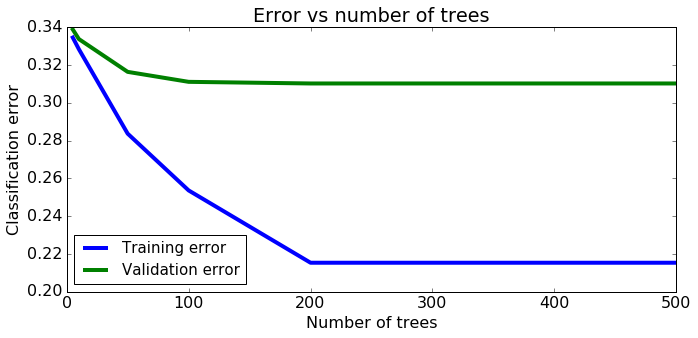

In [332]:
#In this section, we will plot the training and validation errors versus the number of trees 
#to get a sense of how these models are performing. 
#We will compare the 10, 50, 100, 200, and 500 tree models. 
#You will need matplotlib in order to visualize the plots.

#22. First, make sure this block of code runs on your computer.
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

#In order to plot the classification errors (on the train_data and validation_data) versus the 
#number of trees, we will need lists of all the errors.
training_errors = np.array([[5, 1-model_5.score(train_data_X, train_data_y)], [10, 1-model_10.score(train_data_X, train_data_y)], \
                     [50, 1-model_50.score(train_data_X, train_data_y)], [100, 1-model_100.score(train_data_X, train_data_y)], \
                     [200, 1-model_200.score(train_data_X, train_data_y)], [500, 1-model_200.score(train_data_X, train_data_y) ]])


validation_errors = np.array([[5, 1-model_5.score(val_data_X, val_data_y)], [10, 1-model_10.score(val_data_X, val_data_y)], \
                     [50, 1-model_50.score(val_data_X, val_data_y)], [100, 1-model_100.score(val_data_X, val_data_y)], \
                     [200, 1-model_200.score(val_data_X, val_data_y)], [500, 1-model_200.score(val_data_X, val_data_y) ]])

print(training_errors)
print(validation_errors)
#28. Run the following code to visualize the plots.
plt.plot(training_errors[:,0], training_errors[:,1], linewidth=4.0, label='Training error')
plt.plot(validation_errors[:,0], validation_errors[:,1], linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

print('****************************************************************************************************')
print('Quiz question: Does the training error reduce as the number of trees increases?')
print('Yes')
print('****************************************************************************************************')

print('****************************************************************************************************')
print('Quiz question: Is it always true that the validation error will reduce as the number of trees increases?')
print('No')
print('****************************************************************************************************')
